In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
from keras.metrics import MeanSquaredError, MeanAbsoluteError

In [2]:
df = pd.read_csv('Downloads/dataset_user_rating_v4.csv')
df

,User_id,Id_Nama,Nama,Rating
0,1,1,Tahu Kentang Telur Kuah Santan,1
1,1,2,Paha Kambing Panggang,4
2,1,3,Acar Ikan Nila,3
3,1,4,Gulai Ayam Ala RM Padang,1
4,1,5,429. Ayam Goreng & Tempe Ungkep SambeL Tomat,1
...,...,...,...,...
25915,30,860,Sate Ayam Madura,0
25916,30,861,Sate meranggi,4
25917,30,862,Serabi,2
25918,30,863,Soto Ayam Lamongan,0


In [3]:
df['Rating'].value_counts()

5    4429
4    4373
1    4294
0    4294
3    4288
2    4242
Name: Rating, dtype: int64

In [23]:
# df = df.drop(df[df['Rating'] == 0].index)
# df

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   User_id  25920 non-null  int64 
 1   Id_Nama  25920 non-null  int64 
 2   Nama     25920 non-null  object
 3   Rating   25920 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 810.1+ KB


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
recipe_mapping = {title: idx for idx, title in enumerate(df['Id_Nama'].unique(), start=1)}
user_mapping = {user: idx for idx, user in enumerate(df['User_id'].unique(), start=1)}

train['Id_Nama'] = train['Id_Nama'].map(recipe_mapping)
train['User_id'] = train['User_id'].map(user_mapping)

test['Id_Nama'] = test['Id_Nama'].map(recipe_mapping)
test['User_id'] = test['User_id'].map(user_mapping)

n_recipe = len(recipe_mapping)
n_users = len(user_mapping)

In [7]:
# creating recipe embedding path
recipe_input = Input(shape=[1], name="Recipe-Input")
recipe_embedding = Embedding(n_recipe+1, 5, name="Recipe-Embedding")(recipe_input)
recipe_vec = Flatten(name="Flatten-Recipe")(recipe_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([recipe_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(256, activation='relu')(conc)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = Dense(128, activation='relu')(fc2)
out = Dense(1)(fc3)

# Create model and compile it
model = Model([user_input, recipe_input], out)

mse_metric = MeanSquaredError()
mae_metric = MeanAbsoluteError()

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[mse_metric, mae_metric])
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[mse_metric, mae_metric])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Recipe-Input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Recipe-Embedding (Embedding)   (None, 1, 5)         4325        ['Recipe-Input[0][0]']           
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         155         ['User-Input[0][0]']             
                                                                                              

In [9]:
history = model.fit([train.User_id, train.Id_Nama], train.Rating, epochs=700, verbose=1)

Epoch 1/700
648/648 [==============================] - 3s 2ms/step - loss: 1.5344 - mean_squared_error: 3.1964 - mean_absolute_error: 1.5344
Epoch 2/700
648/648 [==============================] - 2s 3ms/step - loss: 1.5033 - mean_squared_error: 3.0168 - mean_absolute_error: 1.5033
Epoch 3/700
648/648 [==============================] - 2s 3ms/step - loss: 1.4769 - mean_squared_error: 2.9687 - mean_absolute_error: 1.4769
Epoch 4/700
648/648 [==============================] - 2s 3ms/step - loss: 1.4602 - mean_squared_error: 2.9421 - mean_absolute_error: 1.4602
Epoch 5/700
648/648 [==============================] - 2s 3ms/step - loss: 1.4411 - mean_squared_error: 2.8922 - mean_absolute_error: 1.4411
Epoch 6/700
648/648 [==============================] - 2s 3ms/step - loss: 1.4240 - mean_squared_error: 2.8652 - mean_absolute_error: 1.4240
Epoch 7/700
648/648 [==============================] - 2s 3ms/step - loss: 1.4073 - mean_squared_error: 2.8493 - mean_absolute_error: 1.4073
Epoch 8/700
6

In [10]:
model.evaluate([test.User_id, test.Id_Nama], test.Rating)

162/162 [==============================] - 1s 2ms/step - loss: 1.9241 - mean_squared_error: 5.4708 - mean_absolute_error: 1.9241


[1.9240800142288208, 5.470828533172607, 1.9240800142288208]

Text(0, 0.5, 'Training Error')

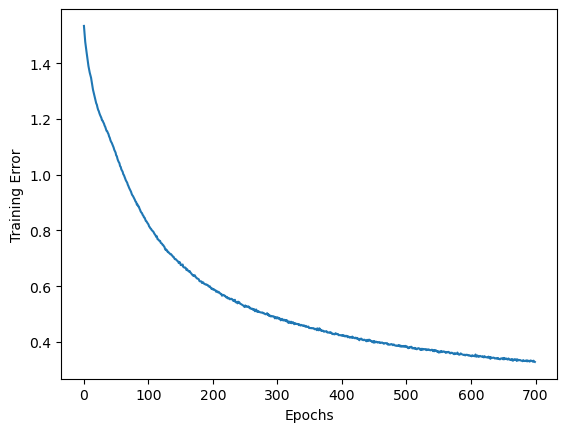

In [11]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

Text(0, 0.5, 'Training Error')

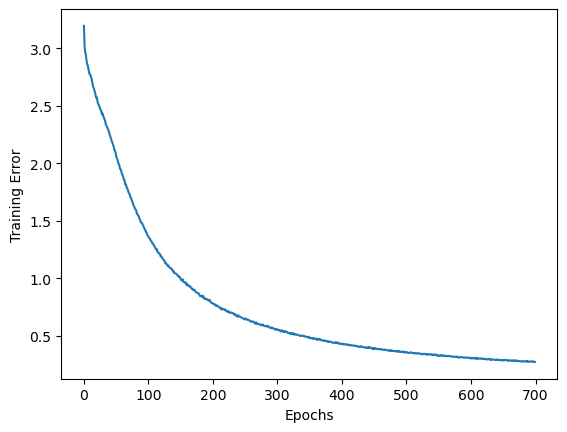

In [12]:
plt.plot(history.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [13]:
id_place = range(1,20)

# Creating data for making recommendations for the certain user
recipe_data = np.array(list(set(df.Id_Nama)))
recipe_data[:10]

id_user = 1
user = np.array([id_user for i in range(len(recipe_data))])
user[:10]

predictions = model.predict([user, recipe_data])

predictions = np.array([a[0] for a in predictions])

recommended_recipe_ids = (-predictions).argsort()[:10]

recommended_recipe_ids

# print predicted scores
print(predictions[recommended_recipe_ids])

print(recommended_recipe_ids)

27/27 [==============================] - 0s 2ms/step
[6.6160374 5.876582  5.8019285 5.6406384 5.637538  5.6077657 5.592929
 5.5914326 5.5767174 5.483656 ]
[536 503 478 418 153 774 659  69 738 329]


In [14]:
print("10 Recommendation recipe for you")
print()
recipe_name = df[df['Id_Nama'].isin(recommended_recipe_ids)]['Nama'].unique()
for i in range(len(recipe_name)):
    print(i+1, recipe_name[i])

10 Recommendation recipe for you

1 Kepala Ayam Goreng Sereh ala rumah
2 Mie goreng telur kornet batita
3 Beef teriyaki simple
4 Soto Ayam Blok S
5 Bobor pucuk labu dan tempe
6 Bakso Daging Sapi
7 Martabak tahu keju
8 Sup bening udang 🍤+tahu
9 Tumis udang sayuran
10 Sate ayam khas senayan ala chef devina


In [15]:
from keras.models import load_model

# saved model
model.save('./model_recommendation_for_you_v4.h5')

# load model
modelv2 = load_model('./model_recommendation_for_you_v4.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(modelv2)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('converted_model_recommendation_for_you_v4.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\santi\AppData\Local\Temp\tmp2xckxgca\assets


INFO:tensorflow:Assets written to: C:\Users\santi\AppData\Local\Temp\tmp2xckxgca\assets


In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the Keras model from .h5 file
keras_model = load_model('./model_recommendation_for_you_v4.h5')

# Convert the Keras model to TensorFlow's SavedModel format (.pb)
model_dir = 'saved_model/version 4'
tf.saved_model.save(keras_model, model_dir)

INFO:tensorflow:Assets written to: saved_model/version 4\assets


INFO:tensorflow:Assets written to: saved_model/version 4\assets
